# Mini-batch stochastic gradient descent and momentum

Your task will be to implement SGD with and without momentum for a binary logistic regression classifier.

As usual, the logistic regression model is defined as follows

$p_1 = p(x;w) = \sigma(w^T x),$

$p_2=(1 - p).$

The log likelihood for each of the training samples is given by:
\begin{equation*}
L(x_i;w)=  y_i \text{log } p(x_i;w) + (1-y_i) \text{log } (1-p(x_i;w)),
\end{equation*}

and the gradient for a set of training samples combined into a matrix $X$ can be expressed as:

\begin{equation*}
\frac{\partial L}{\partial w} = X^T (y - p).
\end{equation*}

For a minibatch of the size $N$, the average gradient over the samples of the minibatch $X_{minibatch}$ is given by:

\begin{equation*}
g = \frac{1}{N} \frac{\partial L}{\partial w} = \frac{1}{N} \text{ } X_{minibatch}^T (y - p),
\end{equation*}

So, the SGD update for the negative log-likelihood is given by

\begin{equation*}
w_{new} = w + g.
\end{equation*}

So, your task is to implement the following two methods:

1. Mini-batch SGD
2. Mini-batch SGD with momentum.

Use the same dataset with handwritten digits. Try to play with the batch sizes and learning rates to achieve the fastest convergence. Try different momentum values, e.g. 0.5, 0.6, ..., 0.9.

You are expected to produce the plots for the training set loss value and accuracy similar to the examples below.
So, you need to plot three curves (train set objective, train set accuracy, test set accuracy) for each of the methods.
Report only the best result for each of the methods among with its parameters like batch size and learning rate.

The the structure of the code might look as follows.

**Bonus**

Implement one of more of the more advanced methods that you like most. It could be Adagrad, RMSProp or ADAM.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing  import  StandardScaler
from sklearn.utils  import  shuffle
from sklearn.datasets import fetch_mldata

C:\Users\serge\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def cost_function(beta, X, y, lam):
    cost2 = 0
    for b_i in range(len(beta)):
        cost2 += b_i**2
    cost2 = lam*cost2
    h = sigmoid(beta@X.T)
    cost1 = -sum(y*np.log(h + 10**-8) + (1-y)*np.log(1 - h + 10**-8))# + lam*2*beta
    return (cost1+cost2)/(len(X[0]))

def sigmoid(x):
    return 1/(1+np.exp(-x))

def score(data, targets, w):
    true_predict = 0
    for i in range(len(targets)):
        y = sigmoid(w@data[i])
        if abs(y - targets[i]) <= 0.5:
            true_predict += 1
    return true_predict/len(targets)

def feature_scale(x):
    scaler = StandardScaler()
    scaler.fit(x[ :, 1:])
    x_norm = scaler.transform (x[ :, 1:])
    X_scaled = (np.concatenate((x[ :, :1].T, x_norm.T), axis=0)).T
    return X_scaled

In [3]:
def iterate_minibatches(X, y, batchsize):
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    X_batches = []
    y_batches = []
    for start_idx in range(0, len(y) - batchsize + 1, batchsize):
        batch_indices = indices[start_idx:start_idx + batchsize]
        X_i = [X[i] for i in batch_indices]
        y_i = [y[i] for i in batch_indices]
        X_batches.append(np.array(X_i))
        y_batches.append(np.array(y_i))
    return X_batches, y_batches

In [4]:
def logistic_regression_SGD(X, y, lam, alpha, n_batches,  max_cost_before_break=1000,  max_count = 1000):
    beta = np.zeros(X.shape[1])
    cnt = 0
    costs = []
    X_1, y_1 = iterate_minibatches(X, y, n_batches)
    while True:
        l_i = []
        for i in range(len(y_1)):
            h = sigmoid(beta@X_1[i].T)
            beta -= alpha*(-y_1[i] + h)@X_1[i]/n_batches  + lam*2*beta
            l_i.append(cost_function(beta, X_1[i], y_1[i], lam))
        costs.append([cnt, np.mean(l_i)])
        if cnt > max_count:
            break
        cnt += 1
    return beta, costs

In [5]:
def logistic_regression_SGD_with_momentum(X, y, lam, alpha, gamma, n_batches,  max_cost_before_break=1000,  max_count = 1000):
    beta = np.zeros(X.shape[1])
    cnt = 0
    costs = []
    X_1, y_1 = iterate_minibatches(X, y, n_batches)
    velocity = 0
    while True:
        l_i = []
        for i in range(len(y_1)):
            h = sigmoid(beta@X_1[i].T)
            velocity = gamma * velocity +  (-y_1[i] + h)@X_1[i]/n_batches  + lam*2*beta
            beta -= alpha *velocity
            l_i.append(cost_function(beta, X_1[i], y_1[i], lam))
        costs.append([cnt, np.mean(l_i)])
        if cnt > max_count:
            break
        cnt += 1
    return beta, costs

In [33]:
def logistic_regression_Adam(X, y, lam, alpha, y1, y2, n_batches,  max_cost_before_break=1000,  max_count = 1000):
    beta = np.zeros(X.shape[1])
    cnt = 0
    eps = 0.00000001
    costs = []
    X_1, y_1 = iterate_minibatches(X, y, n_batches)
    m = 0
    g = 0
    m_t = 0
    g_t = 0
    #  γ1,γ2,η,λ  
    while True:
        l_i = []
        for i in range(1,len(y_1)):
            h = sigmoid(beta@X_1[i].T)
            grad = (-y_1[i] + h)@X_1[i]/n_batches + lam*2*beta
            m = y1*m + (1-y1)*grad
            g = y2*g + (1-y2)*grad**2
            m_t = m/(1-y1**i)
            g_t = g/(1-y2**i)
            beta-= alpha*m_t/np.sqrt(g_t+eps)
            l_i.append(cost_function(beta, X_1[i], y_1[i], lam))
        costs.append([cnt, np.mean(l_i)])
        if cnt > max_count:
            break
        cnt += 1
    return beta, costs

In [7]:
mnist = fetch_mldata('MNIST original')
y = mnist.target
X = mnist.data.astype('float64')
data = []
targets = []
x0 = np.array(len(X)*[1])
X = np.vstack((x0.T, np.array(X).T)).T
X = feature_scale(X)
X, y = shuffle(X, y)
for i in range(len(y)):
    if y[i] == 4:
        targets.append(1)
        data.append(X[i])
    if y[i] == 9:
        targets.append(0)
        data.append(X[i])
X_train, X_test, y_train, y_test = train_test_split(np.array(data), np.array(targets), test_size = 0.2, random_state = 7)

In [64]:
lam = 0.000004
alpha = 0.01
epoch = 21
n_batch = 4
gamma = 0.7

# Минимизация без моментума

In [65]:
beta, costs = logistic_regression_SGD(X_train, y_train, lam, alpha, n_batch, 1000, epoch)
score(X_test, y_test, beta)

0.970620239390642

# Минимизация с моментумом

In [66]:
#for i in range(5, 10):
beta_1, costs_1 = logistic_regression_SGD_with_momentum(X_train, y_train, lam, alpha, gamma, n_batch,  1000, epoch)
print('gamma :', gamma, 'acc:',score(X_test, y_test, beta_1))

gamma : 0.7 acc: 0.9626405513239028


# Adam

In [67]:
gamma_1 = 0.92
gamma_2 = 0.999999999
best_costs = []
best_score = 0
# for i in range(2,10):
#     for j in range(2,10):
#         beta_2, costs_2 = logistic_regression_Adam(X_train, y_train, lam, alpha, i/10, j/10, n_batch,  1000, epoch)
#         if score(X_test, y_test, beta_2) > best_score:
#             best_score = score(X_test, y_test, beta_2)
#             best_costs = costs_2
#             gamma_1 = i/10
#             gamma_2 = j/10
beta_2, costs_2 = logistic_regression_Adam(X_train, y_train, lam, alpha, gamma_1, gamma_2, n_batch,  1000, epoch)
print('gamma_1 :', gamma_1,'gamma_2 :', gamma_2, 'acc:',score(X_test, y_test, beta_2))

gamma_1 : 0.92 gamma_2 : 0.999999999 acc: 0.9662676822633297


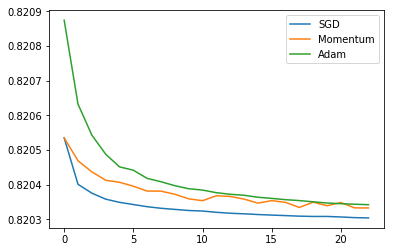

In [69]:
from pylab import *
costs_1 = np.array(costs_1)
costs = np.array(costs)
costs_2 = np.array(costs_2)
plt.plot(costs[:,0],costs[:,1], label='SGD')
plt.plot(costs_1[:,0],costs_1[:,1], label='Momentum')
plt.plot(costs_2[:,0],costs_2[:,1], label='Adam')
legend(('SGD','Momentum','Adam'))
plt.show()